In [21]:
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import norm

from jaxtyping import Num, Float

In [2]:
def effective_sample_size(x: Num[np.ndarray, "t"]) -> float:
    """Calculate effective sample size for time series data."""
    rho = np.array([
        np.cov(x[i:], x[:-i])[0, 1] / np.std(x[i:]) / np.std(x[:-i])
        for i in range(1, x.shape[0] // 2)])
    rho_sum = np.sum(np.maximum(0.0, rho))
    return x.shape[0] / (1 + 2 * rho_sum)

In [3]:
def load_single(path: str) -> dict[str, dict[str, Num[np.ndarray, "t ..."]]]:
    data = {}
    for building in os.listdir(os.path.join(path, "eval")):
        for trace in os.listdir(os.path.join(path, "eval", building)):
            data[trace.replace('.npz', '')] = dict(
                np.load(os.path.join(path, "eval", building, trace)))
    return data


def load_array(
    results: list[str]
) -> dict[str, dict[str, Num[np.ndarray, "nr t ..."]]]:
    traces = [load_single(x) for x in results]
    trace_names = sorted(traces[0].keys())
    data = {}
    for name in trace_names:
        if all(name in t for t in traces):
            data[name] = {
                metric: np.stack([t[name][metric] for t in traces], axis=0)
                for metric in traces[0][name]}

    return data

In [4]:
results = [
    "radarhd/baseline", "radarhd/doppler", "radarhd/unweighted",
    "radartransformer/baseline", "radartransformer/aug-ctd"]

data = load_array([os.path.join("../results", r) for r in results])

In [5]:
def _calculate_stats(trace, key: str = "chamfer"):
    diff = trace["chamfer"][None, :, :] - trace["chamfer"][:, None, :]

    ess = np.zeros(diff.shape[:2])
    for i in range(diff.shape[0]):
        for j in range(diff.shape[1]):
            ess[i, j] += effective_sample_size(diff[i, j])

    return {
        "ess": ess, "n": diff.shape[-1],
        "m1": np.sum(diff, axis=2), "m2": np.sum(diff**2, axis=2)        }


def calculate_stats(
    data: dict[str, dict[str, Num[np.ndarray, "nr t ..."]]],
    key: str = "chamfer"
) -> tuple[
    dict[str, Float[np.ndarray, "nr nr"]],
    dict[str, Float[np.ndarray, "..."]]]:

    _stats = [_calculate_stats(v, key=key) for v in data.values()]
    stats = {k: np.stack([x[k] for x in _stats]) for k in _stats[0]}

    n = np.sum(stats["n"])
    ess = np.sum(stats["ess"], axis=0)
    mean = np.sum(stats["m1"], axis=0) / n
    std = np.sqrt(np.sum(stats["m2"], axis=0) / n - mean**2)
    stderr = std / np.sqrt(ess)
    summary = {
        "mean": mean, "std": std, "ess": ess,
        "stderr": stderr, "zscore": mean / stderr
    }

    return summary, stats


summary, stats = calculate_stats(data, key="chamfer")

/tmp/ipykernel_90123/412561563.py:4: RuntimeWarning: invalid value encountered in scalar divide
  np.cov(x[i:], x[:-i])[0, 1] / np.std(x[i:]) / np.std(x[:-i])


In [6]:
df = []
for i, trace in enumerate(data):
    ess = np.nanmean(stats['ess'][i])
    n = stats['n'][i]
    df.append({
        "trace": trace, "n": n,
        "mean pairwise ess": ess, "discount factor": n / ess,
        "effective sample period (sec)": (n / 10) / ess,
    })
pd.DataFrame(df)

,trace,n,mean pairwise ess,discount factor,effective sample period (sec)
0,cfa.1.fwd,1704,56.724666,30.039842,3.003984
1,cfa.1.lat,1408,57.800601,24.359608,2.435961
2,cfa.3.fwd,2772,67.096865,41.313405,4.131341
3,cfa.3.lat,2213,66.205676,33.426137,3.342614
4,cfa.a.fwd,2937,54.419277,53.969846,5.396985
5,cfa.a.lat,2680,58.617501,45.720134,4.572013
6,morrison.1.fwd,2814,64.788182,43.433847,4.343385
7,morrison.1.lat,1844,53.619789,34.390288,3.439029
8,morrison.2.fwd,1700,45.612775,37.270260,3.727026
9,morrison.2.lat,1489,56.684366,26.268266,2.626827


Text(0.03, 0.02, '2.81 (uncorrected)')

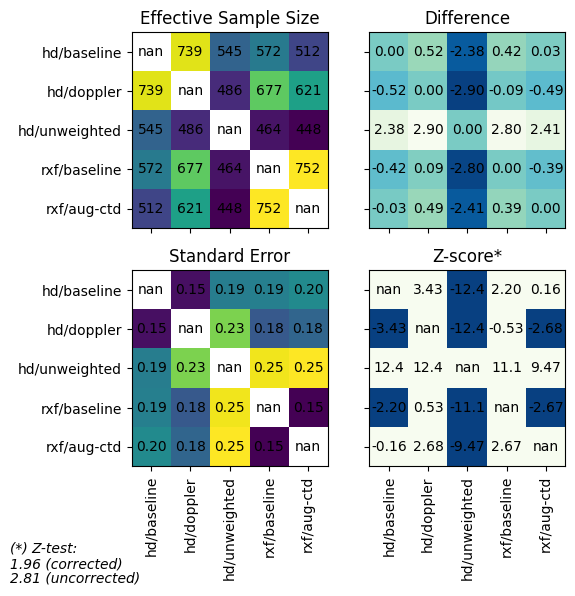

In [39]:
def _matshow(ax, x, cm):
    ax.imshow(x, cmap=cm)
    for (i, j), label in np.ndenumerate(x):
        if abs(label) > 100.0:
            ax.text(i, j, f"{label:.0f}", ha='center', va='center')
        elif abs(label) > 10.0:
            ax.text(i, j, f"{label:.1f}", ha='center', va='center')
        else:
            ax.text(i, j, f"{label:.2f}", ha='center', va='center')
    ax.set_xticks(np.arange(len(results)))
    ax.set_yticks(np.arange(len(results)))
    ax.set_yticklabels([])
    ax.set_xticklabels([])

_stats = {
    "Effective Sample Size": (summary["ess"], "viridis"),
    "Difference": (summary["mean"], "GnBu"),
    "Standard Error": (summary["stderr"], "viridis"),
    "Z-score*": (summary["zscore"], 'GnBu'),
}

# 2-sided test + bonferroni correction
p_target = 0.05 / 2
bonferroni = p_target / ((len(results) * (len(results) - 1)) / 2)
z_uc_cutoff = norm.ppf(1 - p_target)
z_cutoff = norm.ppf(1 - bonferroni)

labels = [
    x.replace("radarhd", "hd").replace("radartransformer", "rxf")
    for x in results]


fig, axs = plt.subplots(2, 2, figsize=(6, 6))
for ax, (sn, (arr, cm)) in zip(axs.reshape(-1), _stats.items()):
    _matshow(ax, arr, cm)
    ax.set_title(sn)

axs[1, 1].imshow(summary["zscore"] > z_uc_cutoff, cmap='GnBu')

for ax in axs[:, 0]:
    ax.set_yticklabels(labels)
for ax in axs[-1]:
    ax.set_xticklabels(labels, rotation=90)

fig.tight_layout()

fig.text(0.03, 0.07, "(*) Z-test:", fontstyle='italic')
fig.text(0.03, 0.045, f"{z_uc_cutoff:.2f} (corrected)", fontstyle='italic')
fig.text(0.03, 0.02, f"{z_cutoff:.2f} (uncorrected)", fontstyle='italic')

